# **Food Commodity Prices Analysis and Forecasting in Kenya**

**By:** Charles Kagwanja   **|**   Kevin Kagia  |   Lucy Njambi  |
 Mwenda Mugambi



---


## **Introduction**
The focus of this project is to analyze and predict the dynamics of food commodity prices in various regions of Kenya. This initiative is essential in a country where agriculture is not only a key economic driver but also vital to the sustenance of its population. The fluctuation in food prices significantly impacts consumers, retailers, farmers, and policymakers. Understanding these price trends and being able to forecast future changes are crucial for effective agricultural planning, budgeting, and policy-making.

### Why This Project Matters

1. **Economic Impact on Farmers and Producers**: Empowering farmers with the knowledge of future price trends, which can guide their crop production and marketing strategies.

2. **Consumer Protection and Budgeting**: Assisting consumers, especially in lower-income groups, to better plan their food budgets.

3. **Policy Making and Food Security**: Enabling policymakers to formulate strategies that can stabilize food markets and ensure food security.

4. **Retail and Distribution Management**: Helping retailers and distributors in optimizing their inventory and pricing strategies.

5. **Aid and Intervention Planning**: Assisting NGOs and international organizations in planning and distributing aid more effectively.

6. **Market Stability and Investment**: Attracting investment in the agricultural sector by providing a clearer understanding of market dynamics.

7. **Research and Development**: Contributing to academic and practical research in market dynamics and agricultural economics.

### Goals of the Project

- **Analyzing Price Trends and Seasonality**: Identify historical patterns in commodity prices across different markets in Kenya.
- **Understanding Regional Variations**: Examine price differences across various regions to understand market dynamics.
- **Forecasting Future Prices**: Develop models to predict future commodity prices.


### Primary Stakeholders

- Kenyan Ministry of Agriculture
- Farmers' Associations and Agricultural Cooperatives
- Retailers and Market Analysts
- Non-Governmental Organizations and International Bodies
- The General Public

## **Business Understanding**

This project aims to provide actionable insights into the trends and future predictions of food commodity prices in Kenya. By leveraging data science and time series forecasting methods, this project seeks to contribute towards more stable and predictable food markets in Kenya.

## **Data Understanding**
### Data Source

The dataset for this project was obtained from the Humanitarian Data Exchange (HDX), specifically from the World Food Programme's food price database for Kenya. The dataset can be accessed [here](https://data.humdata.org/dataset/wfp-food-prices-for-kenya).

This dataset is particularly suitable for our analysis due to the following reasons:
1. **Comprehensiveness**: It covers a wide range of food commodities and spans multiple regions within Kenya.
2. **Relevance**: The data directly relates to the prices of food commodities, which is the central focus of our project.
3. **Timeliness**: The dataset includes recent data, which is crucial for accurate forecasting.

First, we'll load the dataset and take a preliminary look at its structure, types of data it contains, and any initial observations we can make about it.

In [1]:
# Importing necessary Libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
!pip install pystan
!pip install prophet --no-binary :all:
from prophet import Prophet

!pip install pmdarima
from pmdarima import auto_arima
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

  Using cached cmdstanpy-0.9.68.tar.gz (64 kB)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'error'


  error: subprocess-exited-with-error
  
  Getting requirements to build wheel did not run successfully.
  exit code: 1
  
  [18 lines of output]
  Traceback (most recent call last):
    File "C:\Users\ADMIN\anaconda3\envs\learn-env\lib\site-packages\pip\_vendor\pyproject_hooks\_in_process\_in_process.py", line 353, in <module>
      main()
    File "C:\Users\ADMIN\anaconda3\envs\learn-env\lib\site-packages\pip\_vendor\pyproject_hooks\_in_process\_in_process.py", line 335, in main
      json_out['return_val'] = hook(**hook_input['kwargs'])
    File "C:\Users\ADMIN\anaconda3\envs\learn-env\lib\site-packages\pip\_vendor\pyproject_hooks\_in_process\_in_process.py", line 118, in get_requires_for_build_wheel
      return hook(config_settings)
    File "C:\Users\ADMIN\AppData\Local\Temp\pip-build-env-tt7y3__q\overlay\Lib\site-packages\setuptools\build_meta.py", line 325, in get_requires_for_build_wheel
      return self._get_build_requires(config_settings, requirements=['wheel'])
    File "C

### Dataset Overview
Here, we will load the dataset and present its size, and an overview of its features.

In [2]:
# Loading the dataset
data = pd.read_csv('Data/wfp_food_prices_ken.csv')

# Checking the size of the dataset
print(f"\nThe dataset contains {data.shape[0]} rows and {data.shape[1]} columns.\n")


The dataset contains 15736 rows and 14 columns.



In [3]:
# Checking the columns in our dataframe
data.columns

Index(['date', 'admin1', 'admin2', 'market', 'latitude', 'longitude',
       'category', 'commodity', 'unit', 'priceflag', 'pricetype', 'currency',
       'price', 'usdprice'],
      dtype='object')

#### **Column Descriptions**
- <code><b>(date):</b></code>, Indicates the date of the price recording
- <code><b>Administrative Levels (admin1, admin2):</b></code>, Geographical categorizations, Representing different regions and sub-regions in Kenya.
- <code><b>(market):</b></code>,  The specific market where prices were recorded.
- <code><b>(latitude, longitude): </b></code>,  The geographical location of each market.
- <code><b> (category): </b></code>, The type of food commodity (e.g., cereals, pulses).
- <code><b> (commodity): </b></code>, The specific food item (e.g., Maize, Beans).
- <code><b> (unit): </b></code>,The unit of measurement for the price.
- <code><b> (priceflag): </b></code>, Indicates the nature of the price data (e.g., actual, estimated).
- <code><b> (pricetype): </b></code>, Whether the price is retail or wholesale.
- <code><b> (currency):</b></code>, The currency in which the price is given.
- <code><b> (price): </b></code>, The price of the commodity in Kenyan Shillings.
- <code><b> (usdprice): </b></code>,  The price converted to US Dollars.

In [4]:
# Renaming the 'admin1' and 'admin2' columns to more understandable names
data = data.rename(columns={'admin1': 'region', 'admin2': 'district'})

In [5]:
# Displaying general information about the dataset
# to confirm if the datatypes in the description match the expected entries in our dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15736 entries, 0 to 15735
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   date       15736 non-null  object
 1   region     15736 non-null  object
 2   district   15736 non-null  object
 3   market     15736 non-null  object
 4   latitude   15736 non-null  object
 5   longitude  15736 non-null  object
 6   category   15736 non-null  object
 7   commodity  15736 non-null  object
 8   unit       15736 non-null  object
 9   priceflag  15736 non-null  object
 10  pricetype  15736 non-null  object
 11  currency   15736 non-null  object
 12  price      15736 non-null  object
 13  usdprice   15736 non-null  object
dtypes: object(14)
memory usage: 1.7+ MB


In [6]:
# Displaying data entries to get a glimpse of our dataset.
data

,date,region,district,market,latitude,longitude,category,commodity,unit,priceflag,pricetype,currency,price,usdprice
0,#date,#adm1+name,#adm2+name,#loc+market+name,#geo+lat,#geo+lon,#item+type,#item+name,#item+unit,#item+price+flag,#item+price+type,#currency,#value,#value+usd
1,2006-01-15,Coast,Mombasa,Mombasa,-4.05,39.666667,cereals and tubers,Maize (white),90 KG,actual,Wholesale,KES,1480.0,20.5041
2,2006-01-15,Coast,Mombasa,Mombasa,-4.05,39.666667,pulses and nuts,Beans,KG,actual,Wholesale,KES,33.63,0.4659
3,2006-01-15,Coast,Mombasa,Mombasa,-4.05,39.666667,pulses and nuts,Beans (dry),90 KG,actual,Wholesale,KES,3246.0,44.9705
4,2006-01-15,Eastern,Kitui,Kitui,-1.366667,38.016667,cereals and tubers,Maize (white),KG,actual,Retail,KES,17.0,0.2355
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15731,2023-08-15,North Eastern,Garissa,Dagahaley (Daadab),0.185656,40.291621,miscellaneous food,Salt,200 G,aggregate,Retail,KES,10.0,0.07
15732,2023-08-15,North Eastern,Garissa,Dagahaley (Daadab),0.185656,40.291621,miscellaneous food,Sugar,KG,aggregate,Retail,KES,138.46,0.9696
15733,2023-08-15,North Eastern,Garissa,Dagahaley (Daadab),0.185656,40.291621,oil and fats,Oil (vegetable),L,aggregate,Retail,KES,259.23,1.8153
15734,2023-08-15,North Eastern,Garissa,Dagahaley (Daadab),0.185656,40.291621,pulses and nuts,Beans (dry),KG,aggregate,Retail,KES,191.67,1.3422


### Initial cleaning of the dataset

From these outputs, we can see that the first row seems to contain unnecessary headers. We can go ahead and drop that row.
We will also go ahead to convert the **date, latitude, longitude, price,** and **usdprice** columns to their appropriate data types.

In [7]:
# Removing the first row
data = data.drop(index=0)
print(f"\nThe dataset now contains {data.shape[0]} rows and {data.shape[1]} columns after dropping the first row.\n")

# Converting appropriate columns to their correct data types
data['date'] = pd.to_datetime(data['date'])
data['price'] = pd.to_numeric(data['price'], errors='coerce')


The dataset now contains 15735 rows and 14 columns after dropping the first row.



In [8]:
#Confirming the change to the data types
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15735 entries, 1 to 15735
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   date       15735 non-null  datetime64[ns]
 1   region     15735 non-null  object        
 2   district   15735 non-null  object        
 3   market     15735 non-null  object        
 4   latitude   15735 non-null  object        
 5   longitude  15735 non-null  object        
 6   category   15735 non-null  object        
 7   commodity  15735 non-null  object        
 8   unit       15735 non-null  object        
 9   priceflag  15735 non-null  object        
 10  pricetype  15735 non-null  object        
 11  currency   15735 non-null  object        
 12  price      15735 non-null  float64       
 13  usdprice   15735 non-null  object        
dtypes: datetime64[ns](1), float64(1), object(12)
memory usage: 1.8+ MB


Great. now we can see that the datatypes have been updated to the appropriate types and we can also see that we don't have any missing values, we can proceed to drop some columns **'region', 'category', 'priceflag', 'usdprice', 'longitude'** and **'latitude'** will not be necessary in our analysis.

In [9]:
# Listing of columns to drop
columns_to_drop = ['region', 'category', 'priceflag', 'usdprice', 'longitude', 'latitude']

# Dropping the specified columns
data = data.drop(columns=columns_to_drop, errors='ignore')

###  Basic Statistics
In this section, We'll get a brief statistical overview of the numerical features in the dataset.

In [10]:
# Displaying basic statistics
data.describe(include='all')

,date,district,market,commodity,unit,pricetype,currency,price
count,15735,15735,15735,15735,15735,15735,15735,15735.000000
unique,212,22,62,47,14,2,1,NaN
top,2021-04-15 00:00:00,Nairobi,Nairobi,Maize (white),KG,Wholesale,KES,NaN
freq,600,3516,1763,1785,6429,8454,15735,NaN
first,2006-01-15 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,2023-08-15 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2025.314464
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3042.076888
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.000000
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,60.000000


* The dataset covers a time span from **January 2006** to **August 2023**.
* It includes 22 Districts in Kenya, with **62 different markets represented.**
* There are **47 unique commodities**, with **'Maize (white)'** being the most frequent.
* Prices vary significantly, with some commodities having prices as low as **5 KES** and as high as **19,800 KES**. The average price is around **2025 KES**.
* The dataset includes both **wholesale and retail price** types.

## Univariate Analysis
In this section, wIn this stage, we'll analyze individual variables (features) to understand their characteristics. This includes distribution, central tendency, variability, and presence of outliers.e take a deeper aproach into our analysis to find more trends that may inform our next steps

### Price Distribution
We'll start by examining the distribution of commodity prices (in Kenyan Shilling) to understand its range, central tendency, and any potential skewness or outliers.

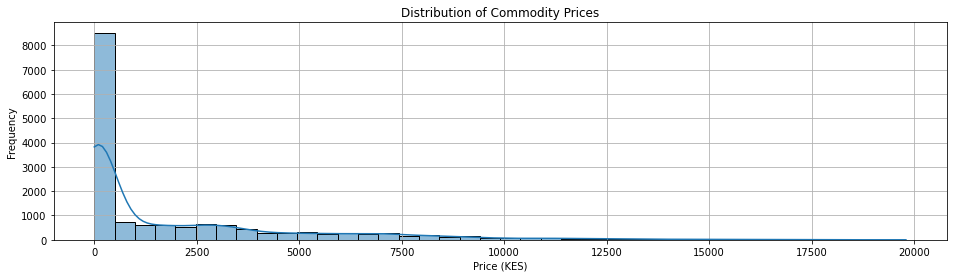

In [11]:
# Plotting the distribution of prices
plt.figure(figsize=(16, 4))
sns.histplot(data['price'], kde=True, bins= 40)
plt.title('Distribution of Commodity Prices')
plt.xlabel('Price (KES)')
plt.ylabel('Frequency')
plt.grid()
plt.show()

The histogram shows a highly right-skewed distribution. This suggests that most commodity prices are on the lower end, with a few commodities having significantly higher prices.

The presence of a long tail indicates substantial variation in prices, with a small number of commodities being much more expensive than the majority.

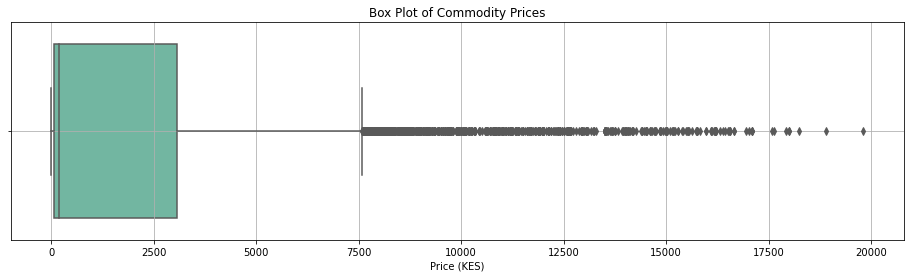

In [12]:
# Boxplot for commodity prices to identify outliers
plt.figure(figsize = (16, 4))
sns.boxplot(x = data['price'], palette = 'Set2')
plt.title('Box Plot of Commodity Prices')
plt.xlabel('Price (KES)')
plt.grid()
plt.show()

The box plot further illustrates the skewness in the data with many outliers on the higher end. These outliers represent commodities with exceptionally high prices.
The median price (indicated by the line inside the box) is relatively low compared to the maximum price, reinforcing the notion of a skewed distribution.

### Comodity Frequencies
Let's create a bar plot to show the frequency of different commodities in the dataset. This will help us understand which commodities are most common and might be of greater interest for further analysis. ​

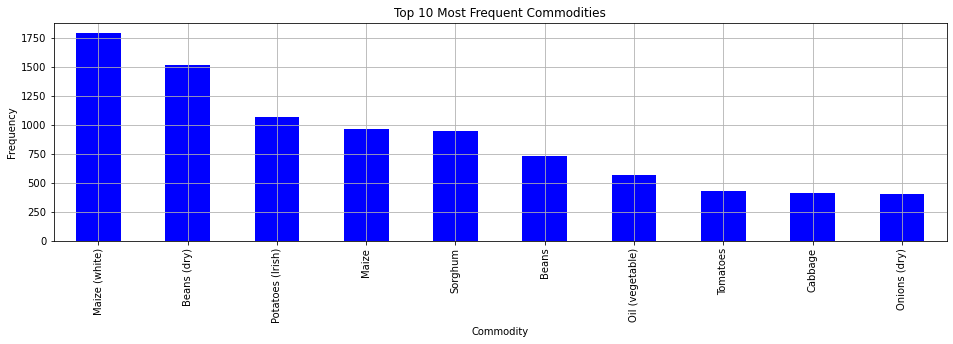

In [13]:
# Top 10 most frequent commodities in the dataset
top_commodities = data['commodity'].value_counts().head(10)

plt.figure(figsize=(16, 4))
top_commodities.plot(kind='bar', color='blue')
plt.title('Top 10 Most Frequent Commodities')
plt.xlabel('Commodity')
plt.ylabel('Frequency')
plt.xticks(rotation=90)
plt.grid()
plt.show()

### District Distribution Analysis

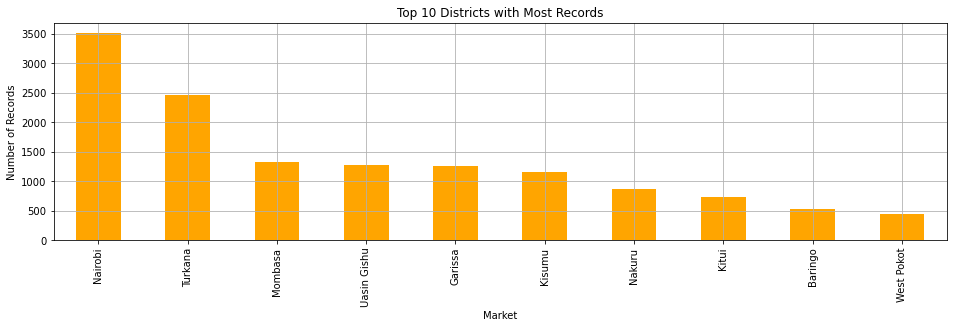

In [14]:
# Re-running the code for Top 10 districts with the most records in the dataset
top_markets = data['district'].value_counts().head(10)

plt.figure(figsize=(16, 4))
top_markets.plot(kind='bar', color='orange')
plt.title('Top 10 Districts with Most Records')
plt.xlabel('Market')
plt.ylabel('Number of Records')
plt.xticks(rotation=90)
plt.grid()
plt.show()


From this analysis we can see the top 10 districts with the most records in the dataset.
* Markets like **Nairobi**, **Turkana**, **Mombasa** and **Uasin Gishu** are among the most represented, indicating either their larger market size or more frequent data collection.

* This distribution helps in understanding which markets are most prominent in the dataset, which is important for evaluating the representativeness of our analysis and identifying any potential gaps in market coverage.

## Bivariate Analysis
In this section, we'll explore relationships between two variables at a time. This can provide insights into how different variables interact with each other, which is particularly useful for understanding the dynamics of commodity prices in relation to other factors.

###  **Commodity vs. Price**
We'll start by analyzing the commodity prices have changed per variation. Before we do,  We first check the number and type of commodities we have.

In [15]:
# Checking for the value counts of each commodity.
data["commodity"].value_counts().sort_index(ascending=True)

Bananas                       327
Beans                         732
Beans (dolichos)              217
Beans (dry)                  1510
Beans (kidney)                107
Beans (mung)                   56
Beans (rosecoco)              240
Beans (yellow)                359
Bread                         178
Cabbage                       411
Cooking fat                   123
Cowpea leaves                  40
Cowpeas                       206
Fish (omena, dry)              24
Fuel (diesel)                  67
Fuel (kerosene)                67
Fuel (petrol-gasoline)         67
Kale                          387
Maize                         964
Maize (white)                1785
Maize (white, dry)            328
Maize flour                   387
Meat (beef)                   219
Meat (camel)                  122
Meat (goat)                   174
Milk (UHT)                    356
Milk (camel, fresh)            78
Milk (cow, fresh)              18
Milk (cow, pasteurized)       178
Millet (finger

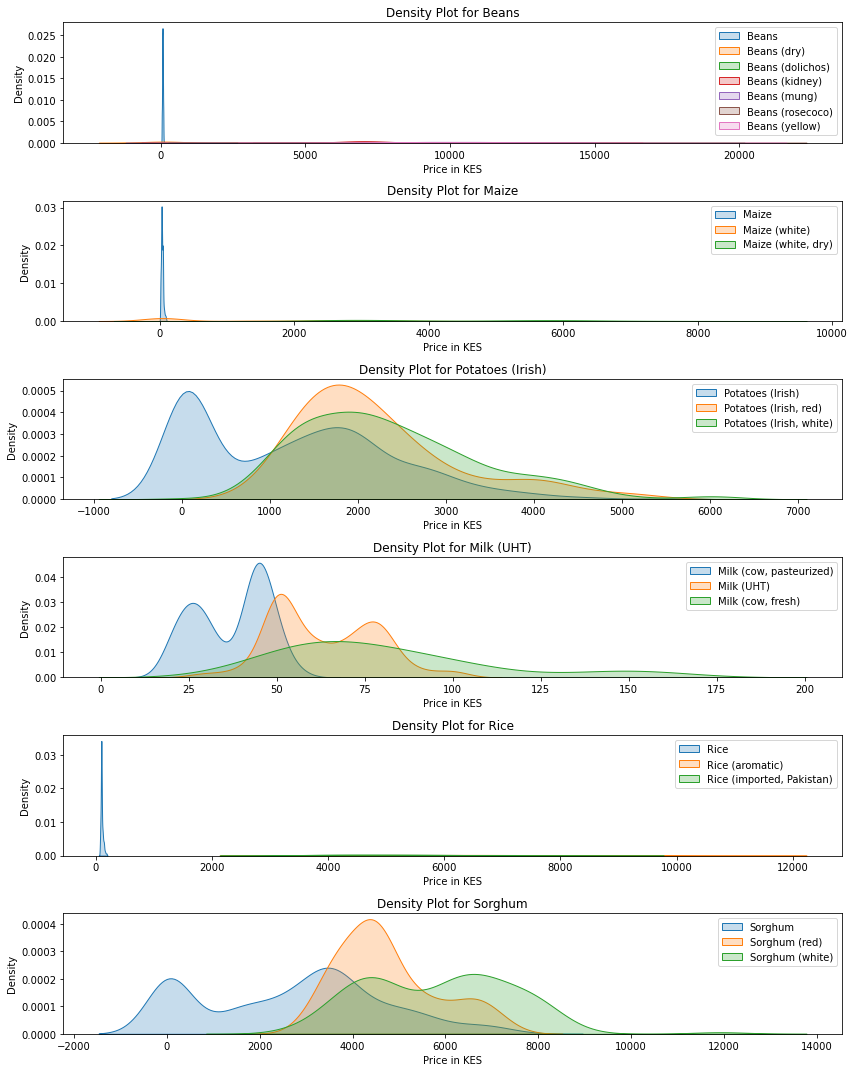

In [16]:
# List of commodity pairs/groups for comparison
commodity_groups = {
    'Beans': ['Beans', 'Beans (dry)', 'Beans (dolichos)','Beans (kidney)',
              'Beans (mung)','Beans (rosecoco)','Beans (yellow)'],

    'Maize': ['Maize', 'Maize (white)', 'Maize (white, dry)'],
    'Potatoes (Irish)': ['Potatoes (Irish)', 'Potatoes (Irish, red)',
                         'Potatoes (Irish, white)'],

    'Milk (UHT)': ['Milk (cow, pasteurized)', 'Milk (UHT)',
                   'Milk (cow, fresh)'],

    'Rice': ['Rice', 'Rice (aromatic)', 'Rice (imported, Pakistan)'],
    'Sorghum': ['Sorghum', 'Sorghum (red)', 'Sorghum (white)'],

}

# density plots for each commodity group
plt.figure(figsize=(12, 15))
for i, (group_name, commodities) in enumerate(commodity_groups.items(), 1):
    plt.subplot(len(commodity_groups), 1, i)
    for commodity in commodities:
        subset = data[data['commodity'] == commodity]
        sns.kdeplot(subset['price'], label=commodity, shade=True)
    plt.title(f'Density Plot for {group_name}')
    plt.xlabel('Price in KES')
    plt.ylabel('Density')
    plt.legend()

plt.tight_layout()
plt.show()

We'll go on to merge the commodities in order to simply our analysis moving on for a general analysis, the goal is to simplify the dataset while still capturing the essence of market variations.

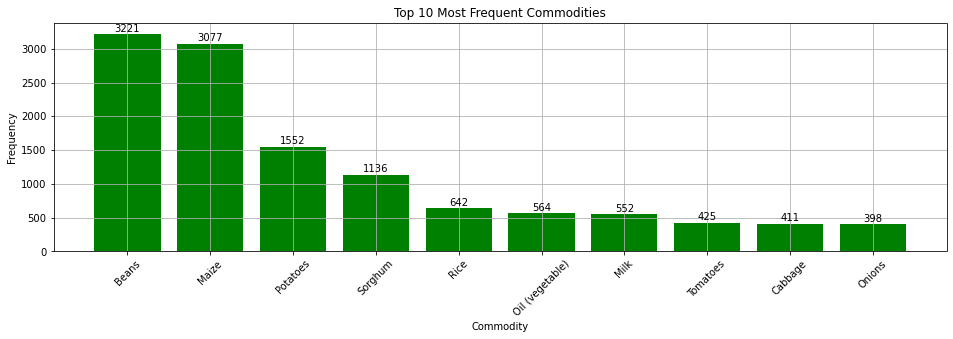

In [17]:
# Defining the mapping of variants to general categories
commodity_replacement = {
    'Beans (dry)': 'Beans',
    'Beans (kidney)': 'Beans',
    'Beans (rosecoco)': 'Beans',
    'Beans (yellow)': 'Beans',
    'Beans (dolichos)': 'Beans',
    'Beans (mung)': 'Beans',
    'Maize (white)': 'Maize',
    'Maize (white, dry)': 'Maize',
    'Potatoes (Irish)': 'Potatoes',
    'Potatoes (Irish, red)': 'Potatoes',
    'Potatoes (Irish, white)': 'Potatoes',
    'Rice (imported, Pakistan)':'Rice',
    'Rice (aromatic)' : 'Rice',
    'Sorghum (white)' : 'Sorghum',
    'Sorghum (red)' : 'Sorghum',
    'Onions (red)' : 'Onions',
    'Onions (dry)': 'Onions',
    'Milk (cow, pasteurized)':'Milk',
    'Milk (UHT)' : 'Milk',
    'Milk (cow, fresh)' : 'Milk'
}

# Updating the 'commodity' column by replacing variant names with the general category name
data['commodity'] = data['commodity'].replace(commodity_replacement)

# Confirming the changes
# Plotting the bar chart with value counts
plt.figure(figsize=(16, 4.2))
top_commodities = data['commodity'].value_counts().head(10)
bars = plt.bar(top_commodities.index, top_commodities.values, color='green')

# Adding the text with the value counts above each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 5, int(yval), ha='center', va='bottom')

plt.title('Top 10 Most Frequent Commodities')
plt.xlabel('Commodity')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.grid()
plt.show()

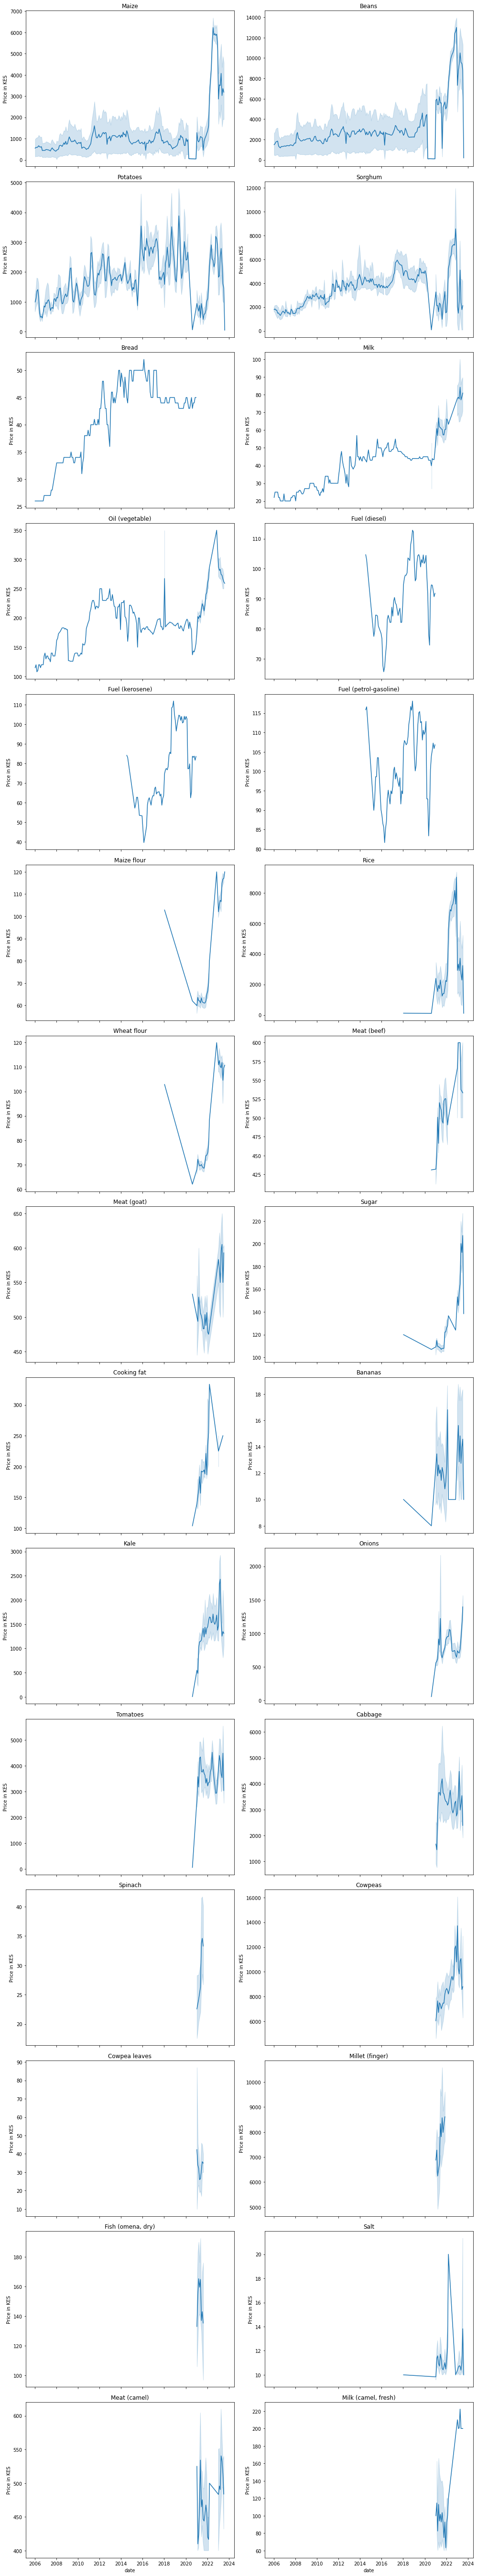

In [18]:
# Setting the date to index
data.set_index('date', inplace=True)

# Get the list of unique commodities
commodities = data['commodity'].unique()

# Calculating the number of rows for the subplots
num_rows = len(commodities) // 2 + (len(commodities) % 2 > 0)

# Setting up the matplotlib figure
fig, axes = plt.subplots(nrows=num_rows, ncols=2, figsize=(14, 5 * num_rows), sharex=True)

# Flattening the axes array for easy iteration
axes = axes.flatten()

# Plotting each commodity's price over time in a subplot
for i, commodity in enumerate(commodities):
    sns.lineplot(data=data[data['commodity'] == commodity]['price'], ax=axes[i])
    axes[i].set_title(commodity)
    axes[i].set_ylabel('Price in KES')

# Remove any unused subplots if commodities are an odd number
if len(commodities) % 2:
    fig.delaxes(axes[-1])

plt.tight_layout()
plt.show();

From this visualization, we can see that not all the commodity prices have been recorded since 2006.
In order to reduce noise, We will go ahead and drop all the commodities that have not been recorded since 2006

In [19]:
# Filtering data to include only commodities with records starting from 2006 or earlier
commodities_since_2006 = data[data.index.year <= 2006]['commodity'].unique()

# Now filtering main dataframe to include only these commodities
filtered_data = data[data['commodity'].isin(commodities_since_2006)]

# After filtering we check the unique commodities and their counts again
filtered_commodity_counts = filtered_data['commodity'].value_counts()
filtered_commodity_counts

Beans              3221
Maize              3077
Potatoes           1552
Sorghum            1136
Oil (vegetable)     564
Milk                552
Bread               178
Name: commodity, dtype: int64

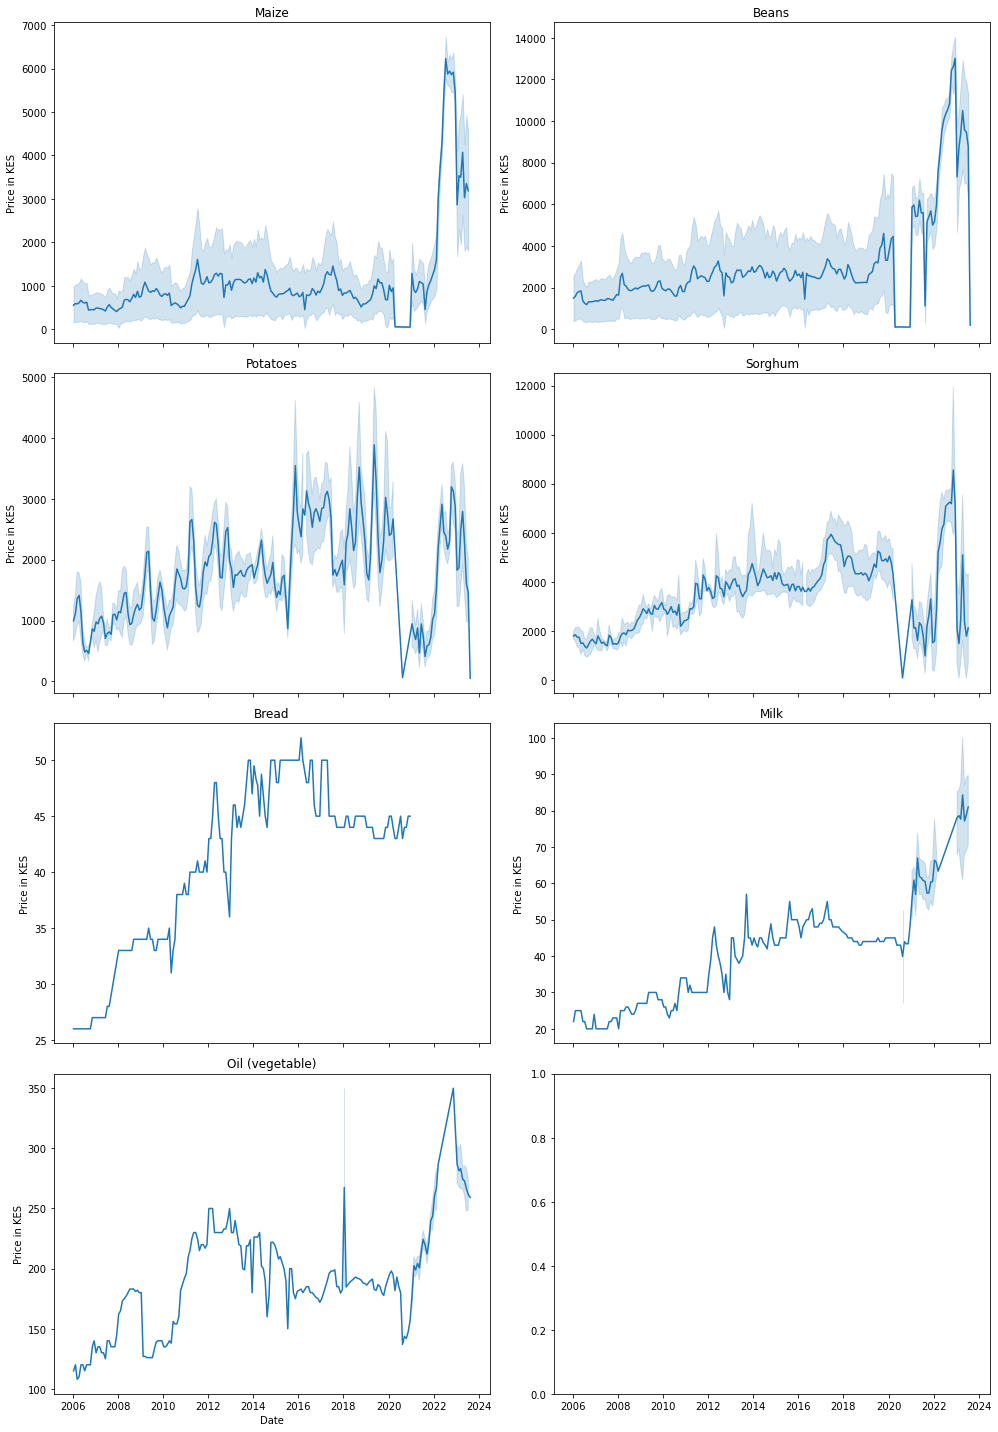

In [20]:
# Getting the list of unique commodities after filtering
commodities = filtered_data['commodity'].unique()

# Calculating the number of rows for the subplots
num_rows = len(commodities) // 2 + (len(commodities) % 2)

# Setying up the matplotlib figure
fig, axes = plt.subplots(nrows=num_rows, ncols=2, figsize=(14, 5 * num_rows), sharex=True)

# Flattening the axes array for easy iteration
axes = axes.flatten()

# Ploting each commodity's price over time in a subplot
for i, commodity in enumerate(commodities):
    sns.lineplot(data=filtered_data[filtered_data['commodity'] == commodity]['price'], ax=axes[i])
    axes[i].set_title(commodity)
    axes[i].set_ylabel('Price in KES')
    axes[i].set_xlabel('Date')

plt.tight_layout()
plt.show();

Great. Now that we have commoditie with substatial data, we can proceed to the next level of our analysis.

### **Price vs. District**
Next, we'll examine the relationship between commodity prices and different districts. This can highlight regional price variations.

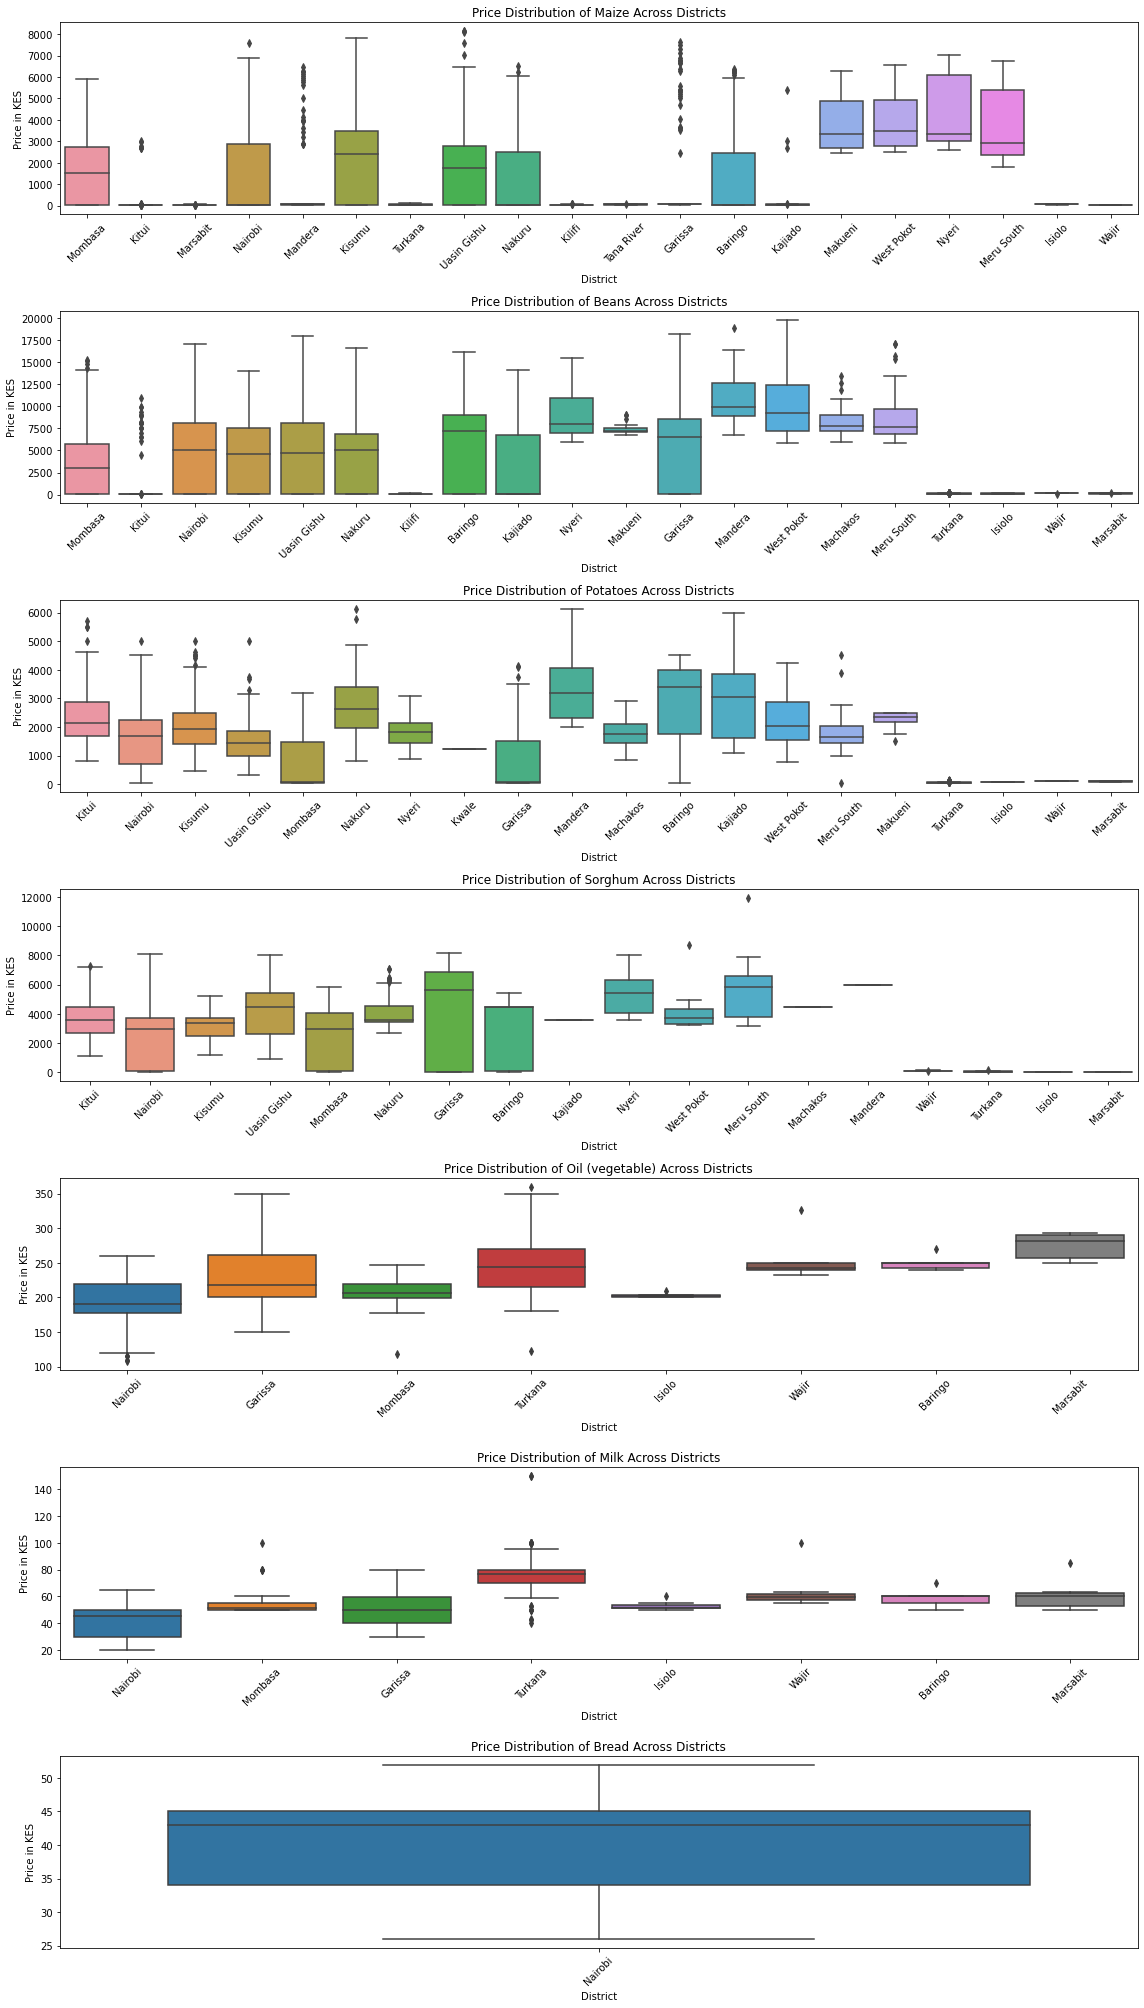

In [21]:
# Selecting the commodities for visualization
key_commodities = ['Maize', 'Beans', 'Potatoes', 'Sorghum', 'Oil (vegetable)', 'Milk', 'Bread' ]

# Seting up the matplotlib figure - adjust the size as needed
num_rows = len(key_commodities)
fig, axes = plt.subplots(nrows=num_rows, ncols=1, figsize=(16, 4*num_rows))

# Flattening the axes array if it's multidimensional
axes = axes.flatten() if num_rows > 1 else [axes]

# box plots for each commodity's price across districts
for i, commodity in enumerate(key_commodities):
    sns.boxplot(data=filtered_data[filtered_data['commodity'] == commodity], x='district', y='price', ax=axes[i])
    axes[i].set_title(f'Price Distribution of {commodity} Across Districts')
    axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45)
    axes[i].set_ylabel('Price in KES')
    axes[i].set_xlabel('District')

plt.tight_layout()
plt.show();

from this analysis, We cans see that
* **Maize** prices vary widely across districts, with some having higher median prices and greater variability, suggesting regional factors influence prices.
* **Beans** also exhibit significant variation, indicating occasional spikes possibly due to seasonal shortages.
* **Potato** prices are relatively consistent across districts, with occasional outliers indicating price surges.
* **Sorghum** prices vary notably, reflecting regional differences in its importance.
* **Vegetable oil** prices are relatively uniform, but some districts show greater price ranges.
* **Milk prices** show less variability, suggesting a more consistent supply chain, though occasional fluctuations occur.
* **Limited data on bread** prices hinders comparative district analysis so we will go on and drop the commodity all together

In [22]:
# Filtering and maintaining rows where the commodity is not "Bread"
filtered_data = filtered_data[filtered_data['commodity'] != 'Bread']
filtered_commodity_counts = filtered_data['commodity'].value_counts()
filtered_commodity_counts

Beans              3221
Maize              3077
Potatoes           1552
Sorghum            1136
Oil (vegetable)     564
Milk                552
Name: commodity, dtype: int64

### Unit vs Commodity
Next we'll analyse our data to understand how many different units we have recorderd per each commodity.

In [23]:
# Grouping for analysis
unit_analysis = filtered_data.groupby(['commodity', 'unit']).size().reset_index(name='count')

# Sorting the results for better readability
unit_analysis = unit_analysis.sort_values(by=['commodity', 'count'], ascending=[True, False])

# Displaying the dataframe
unit_analysis

,commodity,unit,count
0,Beans,90 KG,1712
1,Beans,KG,1509
3,Maize,KG,2016
2,Maize,90 KG,1061
5,Milk,500 ML,533
6,Milk,L,18
4,Milk,200 ML,1
7,Oil (vegetable),L,564
8,Potatoes,50 KG,1189
9,Potatoes,KG,363


* **Beans:** The majority of bean prices are recorded in '90 KG' units, followed by 'KG'. This suggests that beans are commonly traded in bulk.

* **Maize:** Maize prices are commonly reported in both 'KG' and '90 KG', with more records in 'KG'. This reflects the different market segments (retail vs. wholesale).

* **Milk:** Milk is primarily measured in '500 ML' units, with very few records in 'L' and '200 ML'. The dominance of the '500 ML' unit indicates standard packaging size for milk.

* **Oil (Vegetable):** All records for vegetable oil are in liters, which indicates consistency in the unit of measurement for vegetable oil.

* **Potatoes:** Potatoes also have a significant number of records in '50 KG' suggesting bulk trade, but there are also a substantial number of records in 'KG' which might represent smaller purchases or retail sales.

* **Sorghum:** The unit '90 KG' is used for most of the sorghum records, with fewer in 'KG'. This is indicative of bulk trade for sorghum.

To compare prices across all commodities we'll need to standardize the units of measure. For solid commodities like beans, maize, and sorghum, 'KG' could be the standard unit. For the liquids, 'L' (liter) could be the standard.

In [24]:
# Defining the conversion factors
conversion_factors = {
    '90 KG': 1/90,   # Converting prices for 90 KG to price per KG
    'KG': 1,         # No conversion needed
    '500 ML': 2,     # Converting prices for 500 ML to price per L
    'L': 1,          # No conversion needed
    '50 KG': 1/50,   # Converting prices for 50 KG to price per KG
    '200 ML': 5      # Converting prices for 200 ML to price per L
}

# Applying the conversion factors to create a new 'standardized_price' column
filtered_data['standardized_price'] = filtered_data.apply(
    lambda row: row['price'] * conversion_factors.get(row['unit'], 1), axis=1
)


filtered_data = filtered_data.reset_index()
filtered_data = filtered_data.rename(columns={"index":'date'})

# Saving the updated DataFrame to a new CSV file
#filtered_data.to_csv('Data/filtered_data.csv', index=False)

# Sampling the data to confirm the changes
filtered_data.sample(10)

,date,district,market,commodity,unit,pricetype,currency,price,standardized_price
3023,2014-04-15,Uasin Gishu,Eldoret town (Uasin Gishu),Beans,90 KG,Wholesale,KES,9000.00,100.000000
3814,2016-02-15,Nairobi,Nairobi,Maize,KG,Wholesale,KES,31.09,31.090000
2570,2013-02-15,Nairobi,Nairobi,Maize,KG,Wholesale,KES,30.97,30.970000
1813,2011-01-15,Mandera,Mandera,Maize,KG,Retail,KES,50.00,50.000000
5719,2019-11-15,Uasin Gishu,Eldoret town (Uasin Gishu),Beans,90 KG,Wholesale,KES,7965.00,88.500000
8423,2021-04-15,Garissa,Dagahaley (Daadab),Oil (vegetable),L,Retail,KES,195.02,195.020000
2528,2012-12-15,Uasin Gishu,Eldoret town (Uasin Gishu),Sorghum,90 KG,Wholesale,KES,3200.00,35.555556
2507,2012-12-15,Kitui,Kitui,Beans,KG,Retail,KES,77.00,77.000000
3832,2016-02-15,Nakuru,Nakuru,Maize,KG,Wholesale,KES,25.27,25.270000
9643,2022-02-15,Marsabit,Marsabit town,Milk,500 ML,Retail,KES,60.48,120.960000


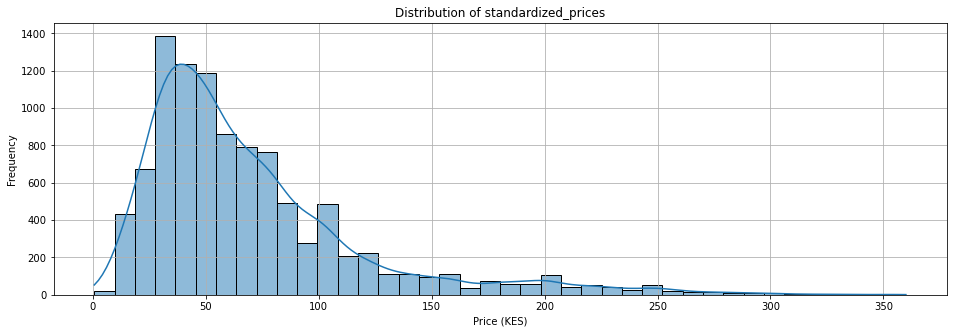

In [25]:
# Plotting the distribution of prices
plt.figure(figsize=(16, 5))
sns.histplot(filtered_data['standardized_price'], kde=True, bins= 40)
plt.title('Distribution of standardized_prices')
plt.xlabel('Price (KES)')
plt.ylabel('Frequency')
plt.grid()
plt.show()

###  Commodity vs  PriceType
Next we'll analyse our data to understand the pricetype distribution per each commodity.

In [26]:
# Grouping the data by commodity and price type
price_type_analysis = filtered_data.groupby(['commodity', 'pricetype']).size().reset_index(name='count')

# Sorting the results for better readabilityc
price_type_analysis = price_type_analysis.sort_values(by=['commodity', 'count'], ascending=[True, False])

# Checking the results
price_type_analysis

,commodity,pricetype,count
1,Beans,Wholesale,2444
0,Beans,Retail,777
3,Maize,Wholesale,1693
2,Maize,Retail,1384
4,Milk,Retail,552
5,Oil (vegetable),Retail,564
7,Potatoes,Wholesale,1189
6,Potatoes,Retail,363
9,Sorghum,Wholesale,902
8,Sorghum,Retail,234


**Beans:** The majority of price records for beans are for wholesale prices, which are more than three times the records for retail prices. This suggests that beans are commonly traded in bulk, and wholesale prices are more frequently reported.

**Maize:** Wholesale prices for maize also have a higher count compared to retail, but the difference is not as pronounced as with beans. This indicates a significant presence of maize in both wholesale and retail markets.

**Milk:** All price records for milk are retail, indicating that the dataset might be capturing consumer prices rather than bulk trading prices.

**Oil (Vegetable):** Similar to milk, all records for vegetable oil are retail prices, suggesting the data reflects end-consumer pricing.

**Potatoes:** The count of wholesale price records is significantly higher than retail for potatoes, indicating a focus on bulk trade within the dataset for this commodity.

**Sorghum:** Wholesale price records outnumber retail ones.

### Temporal Analysis:
Now we'll check how the standardized prices of commodities fluctuate over time due to various factors such as seasonality, demand, broader economic conditions and supply changes.

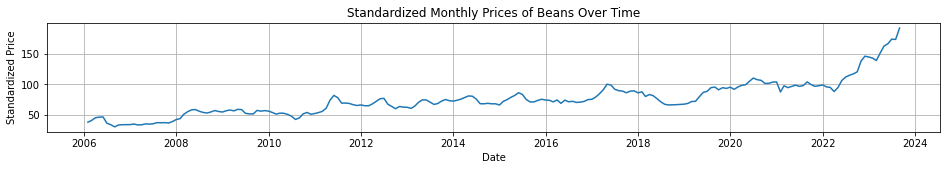

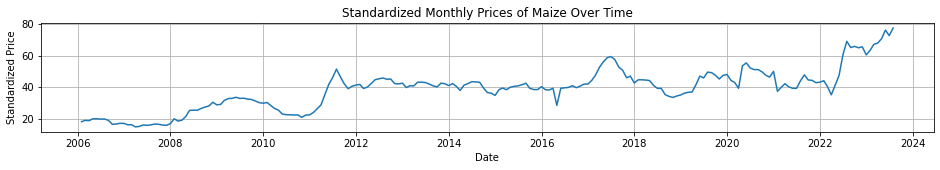

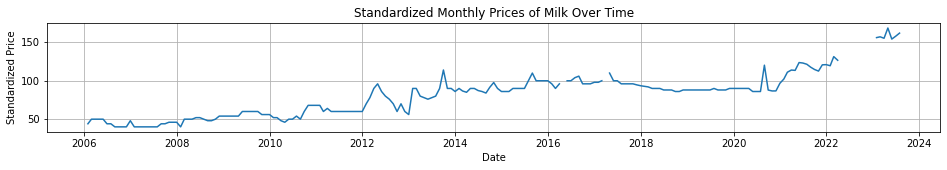

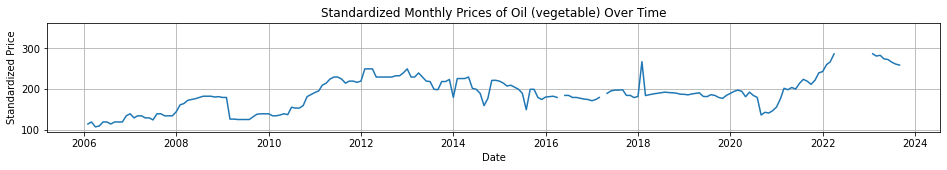

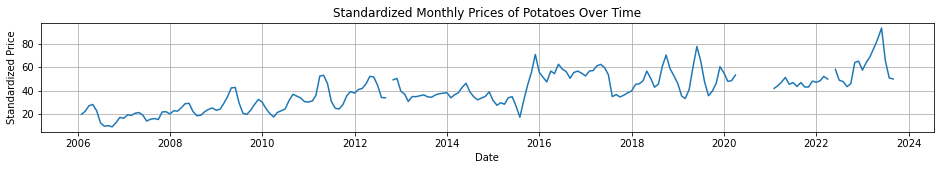

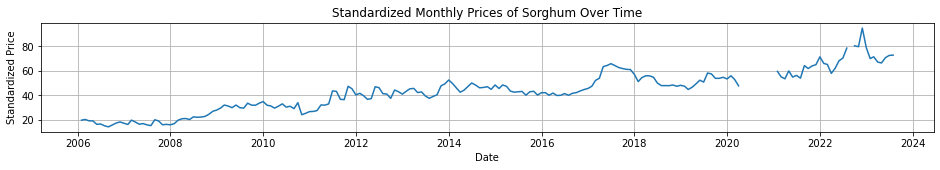

In [27]:
# Grouping by 'commodity' and resample to get monthly means
filtered_data.set_index('date', inplace=True)# Setting the date to index
grouped = filtered_data.groupby('commodity').resample('M')['standardized_price'].mean()

# Resetting the index
grouped = grouped.reset_index()

# Plotting each commodity
commodities = grouped['commodity'].unique()
for commodity in commodities:
    plt.figure(figsize=(16, 2))
    sns.lineplot(
        data=grouped[grouped['commodity'] == commodity],
        x='date',
        y='standardized_price'
    )
    plt.title(f'Standardized Monthly Prices of {commodity} Over Time')
    plt.xlabel('Date')
    plt.ylabel('Standardized Price')
    plt.grid()
    plt.show()

filtered_data = filtered_data.reset_index()
filtered_data = filtered_data.rename(columns={"index":'date'})

The visualizations indicate both **seasonal patterns and long-term trends** in the prices of commodities. These patterns are critical for any predictive modeling efforts.
The fluctuations and trends can be influenced by a variety of factors including **market demand**, **supply chain issues**, **seasonal harvests**, and **broader economic conditions**.
Our predictive model will need to account for these temporal dynamics.

### Outlier Detection:
Next we analyse our data to Identify any outliers since they can distort predictive modeling and can be indicative of data entry errors, unusual market conditions, or true price spikes.

In [28]:
# Creating a function to calculate IQR and identify outliers
def detect_outliers_iqr(data):
    q1 = data.quantile(0.25)
    q3 = data.quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - (1.5 * iqr)
    upper_bound = q3 + (1.5 * iqr)
    outliers = data[(data < lower_bound) | (data > upper_bound)]
    return outliers

# We will now apply this function to each commodity group in our dataset
outliers_by_commodity = {}

for commodity in filtered_data['commodity'].unique():
    commodity_data = filtered_data[filtered_data['commodity'] == commodity]['standardized_price']
    outliers = detect_outliers_iqr(commodity_data)
    outliers_by_commodity[commodity] = outliers

# Displaying the outliers for each commodity
for commodity, outliers in outliers_by_commodity.items():
    print(f"Outliers for {commodity}:")
    print(outliers)
    print("\n")

Outliers for Maize:
2617      82.700000
2648      87.800000
2680      84.750000
2709      86.350000
2732      83.000000
2924      84.000000
3936      84.000000
4276      87.000000
4359      90.700000
4401      92.600000
4407      87.900000
4444      98.000000
4488     100.000000
4529      91.000000
4570      88.000000
4613      87.000000
4828      85.500000
4870      86.300000
4910      85.000000
4954      84.000000
4998      83.000000
5704      85.000000
5942      84.000000
5977      83.000000
7421      90.311111
7519      85.000000
7823      83.333333
7933      84.500000
7963      83.688889
7978      90.422222
7999      84.122222
8013      87.033333
8025      90.000000
9798      85.560000
9804      87.500000
9876      85.000000
9893      90.000000
9907      87.500000
9928     100.000000
9934      90.000000
9938      85.000000
9944      95.000000
9961      92.500000
9965      90.000000
9995      90.000000
10007     90.000000
10016     84.000000
10051     95.000000
10067    100.000000


* **Maize:** Numerous outliers observed between 2013 and 2023, with notable spikes in 2017 and 2023.
Potential indicators of market stress, supply issues, or external factors impacting prices.
* **Beans:** Outliers concentrated in 2021 and 2023, reaching up to 220 units.
Suggestive of high demand or reduced supply, prompting further investigation into market conditions.
* **Potatoes:** Outliers across multiple years, highest prices recorded in 2018 and 2023.
Persistent outliers indicate recurring factors affecting the potato market, potentially linked to seasonal weather impacts.
* **Sorghum:** Fewer outliers compared to other commodities, significant spikes in 2021 and 2023.
* **Milk:** No outliers detected, indicating consistent milk prices without extreme spikes or dips.
* **Oil (Vegetable):** Sporadic outliers across the dataset's timeline, significant spikes in 2018, 2022, and 2023.
Possibly linked to global oil prices or shifts in trade policies, as vegetable oil prices are influenced by international markets.

* **Limitations**: Price trends in the different Districts could be affected by multiple factore includung demand and supply and Transport and Production cost.   

## DATA PREPROCESSING


. We initiate the creation of a nested dictionary to streamline the retrieval of data.

. We establish the nested dictionary using the unique values found in the columns ('pricetype', 'district', and  'commodity') extracted from the filtered_data DataFrame.

In [57]:
nested_dict = {}

for a in range(0, len(filtered_data['pricetype'].unique())):
    pricetype_name = filtered_data['pricetype'].unique()[a]
    nested_dict[pricetype_name] = {}
    df_pricetype = filtered_data[filtered_data['pricetype']==pricetype_name]

    for b in range(0, len(df_pricetype['district'].unique())):
        region_name = df_pricetype['district'].unique()[b]
        nested_dict[pricetype_name][region_name] = {}

        df_region = df_pricetype[df_pricetype['district'] == region_name]


        for d in range(0, len(df_region['commodity'].unique())):
            item_name = df_region['commodity'].unique()[d]
            nested_dict[pricetype_name][region_name][item_name] = df_region[df_region['commodity'] == item_name]

# Access nested_dict as needed
nested_dict.keys()
#nested_dict.values()

dict_keys(['Wholesale', 'Retail'])

The above code results into a nested dictionary *nested_dict* which is a hierarchical structure where data is organized by 'pricetype', then 'district', and finally 'commodity'.

## Generating line plots for standardized prices of commodities over time

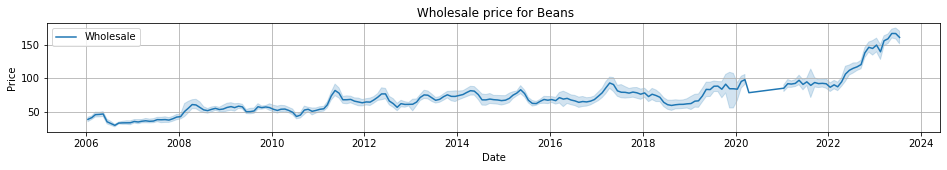

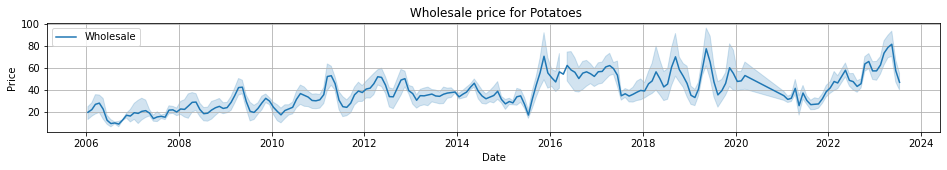

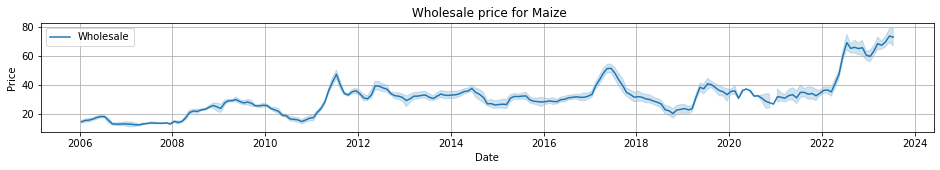

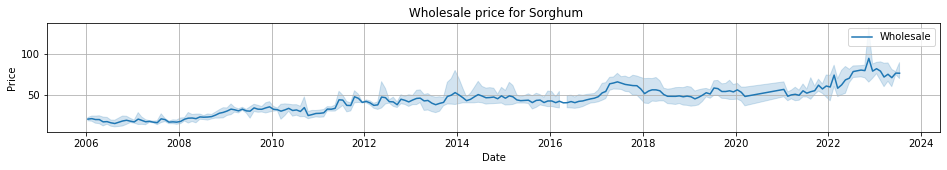

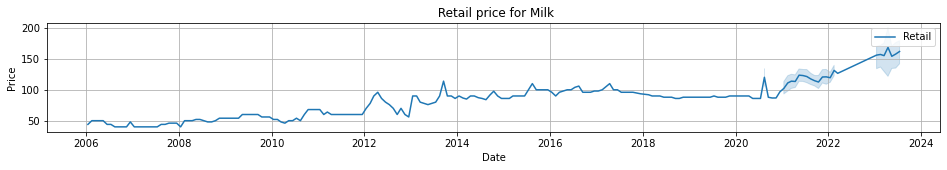

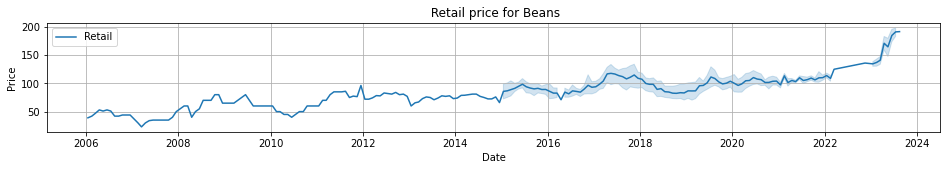

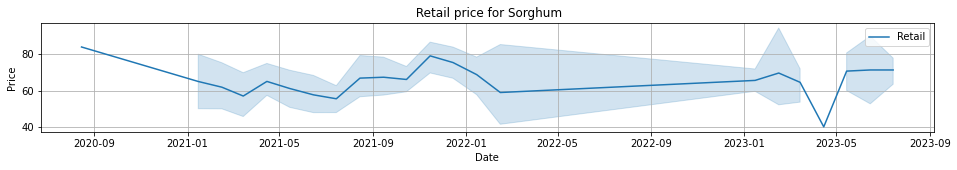

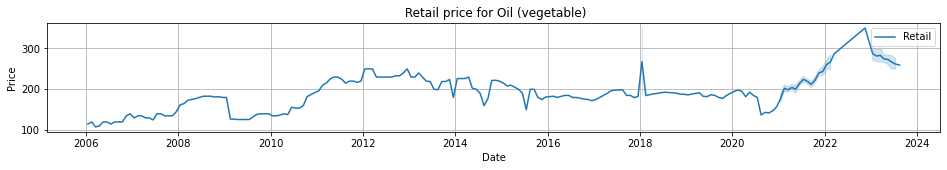

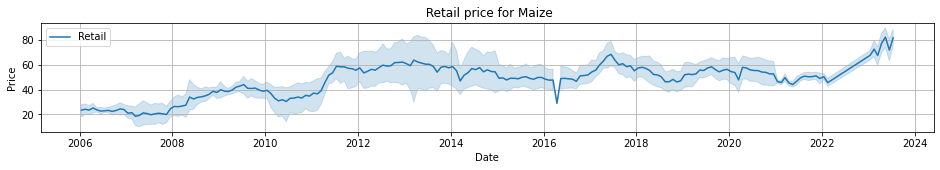

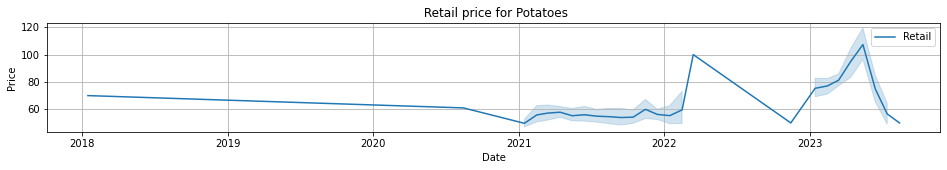

In [30]:
# Iterate through price types
for pricetype_name, pricetype_data in nested_dict.items():

    # Get a list of all unique commodities for the current price type
    unique_commodities = set(commodity for region_data in pricetype_data.values() for commodity in region_data.keys())

    # Iterate through unique commodities
    for commodity_name in unique_commodities:

        # Create an empty DataFrame to accumulate data for the current commodity
        df_commodity = pd.DataFrame()

        # Iterate through regions
        for region_name, region_data in pricetype_data.items():

            # Check if the commodity exists in the current region
            if commodity_name in region_data:
                # Append data for the current commodity in the current region to the DataFrame
                df_commodity = pd.concat([df_commodity, region_data[commodity_name]], ignore_index=True)

        # Check if the DataFrame is not empty and contains 'date' and 'price' columns
        if not df_commodity.empty and 'date' in df_commodity.columns and 'price' in df_commodity.columns:
            # Plotting
            plt.figure(figsize=(16, 2))
            sns.lineplot(
                data=df_commodity,
                x='date',
                y='standardized_price',
                label=pricetype_name
            )
            plt.title(f' {pricetype_name} price for {commodity_name}')
            plt.xlabel('Date')
            plt.ylabel('Price')
            plt.legend()
            plt.grid()
            plt.show()
        else:
            print(f"Skipping plot for {commodity_name} ({pricetype_name}): Empty or missing 'date'/'price' columns.")

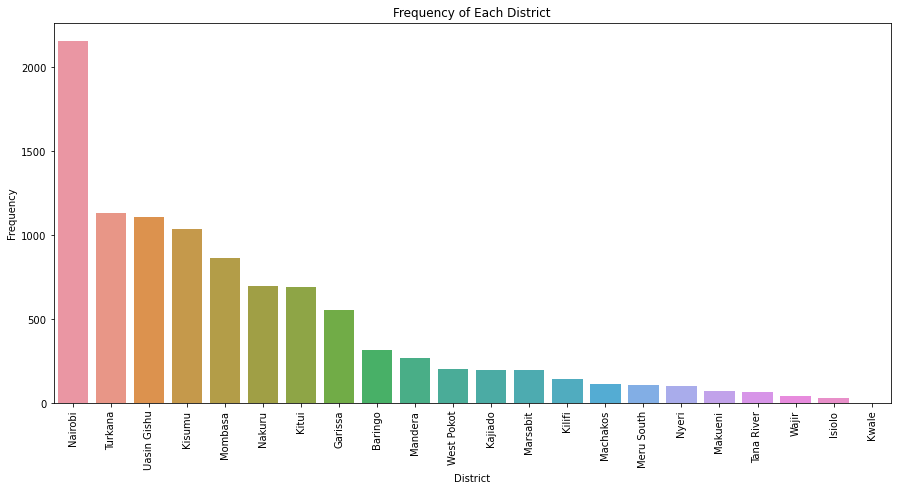

In [58]:
# Generating a bar plot visualization to explore the distribution of entry frequencies across different districts in the dataset.

district_counts = filtered_data['district'].value_counts()

plt.figure(figsize=(15, 7))
sns.barplot(x=district_counts.index, y=district_counts.values)
plt.title('Frequency of Each District')
plt.xlabel('District')
plt.ylabel('Frequency')
plt.xticks(rotation=90)
plt.show()

1. There is a signicant disparity in data representantion.Nairobi has the highest entries while Tana River, Wajir, Isiolo and Kwale have very minimal entries
2. Potential factors contributing to the observed variations in entry frequencies across districts may stem from differences in market transactions and economic activity. Additionally, issues during the data collection stage could also play a role in the disparities.

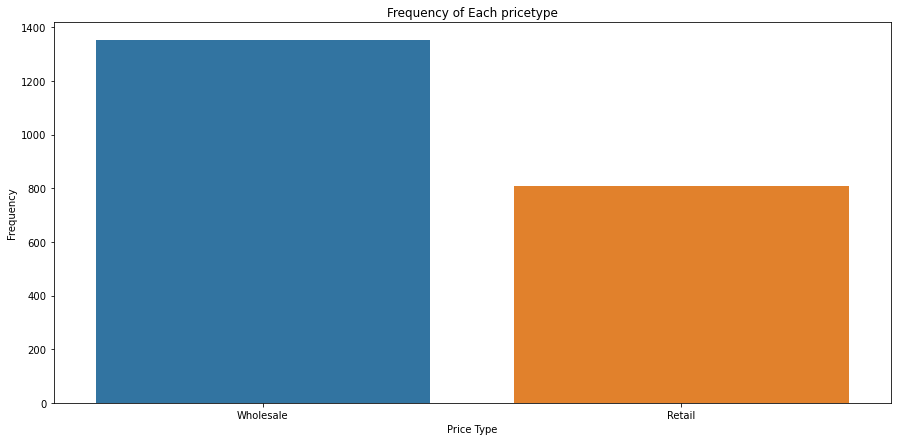

In [59]:
# Bar plot visualization to explore the the frequency distribution of different price types within the 'Nairobi' district 

district_counts = filtered_data[filtered_data['district']=='Nairobi']['pricetype'].value_counts()

plt.figure(figsize=(15, 7))
sns.barplot(x=district_counts.index, y=district_counts.values)
plt.title('Frequency of Each pricetype')
plt.xlabel('Price Type')
plt.ylabel('Frequency')
plt.show()

1. Wholesale emerges as the predominant price type in the Nairobi district.
2. This prevalence may stem from a higher concentration of data collection in markets where small-scale traders procure goods for subsequent retail sales.

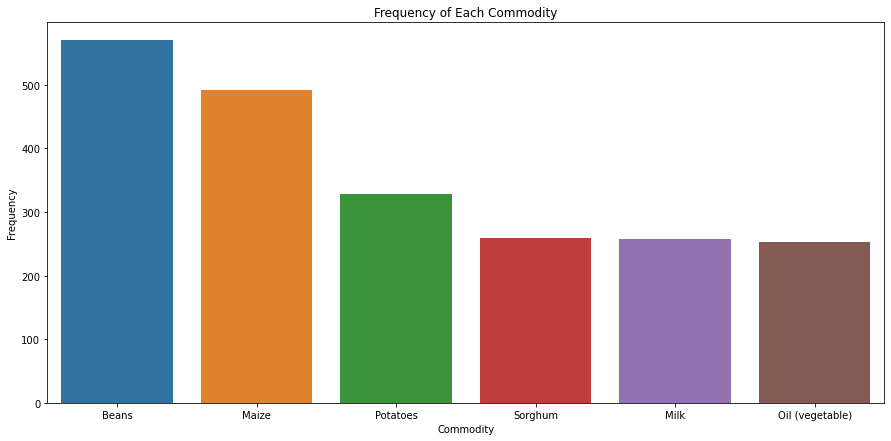

In [33]:
district_counts = filtered_data[filtered_data['district']=='Nairobi']['commodity'].value_counts()

plt.figure(figsize=(15, 7))
sns.barplot(x=district_counts.index, y=district_counts.values)
plt.title('Frequency of Each Commodity')
plt.xlabel('Commodity')
plt.ylabel('Frequency')
plt.show()

In [34]:
# Drop the specified columns
columns_to_drop = ['market', 'unit', 'currency', 'price']
filtered_data.drop(columns=columns_to_drop, inplace=True)

In [35]:
df_nairobi = filtered_data[filtered_data['district'] == 'Nairobi']
df_nairobi.shape


(2160, 5)

In [36]:
df_nairobi=df_nairobi.reset_index()

In [37]:
df_nairobi.head()

,index,date,district,commodity,pricetype,standardized_price
0,8,2006-01-15,Nairobi,Maize,Wholesale,15.480000
1,9,2006-01-15,Nairobi,Maize,Wholesale,15.544444
2,10,2006-01-15,Nairobi,Potatoes,Wholesale,13.288600
3,11,2006-01-15,Nairobi,Sorghum,Wholesale,21.777778
4,12,2006-01-15,Nairobi,Milk,Retail,44.000000


In [38]:
df_nairobi2=df_nairobi
df_nairobi2=df_nairobi2.drop(columns='index')
df_nairobi2.set_index('date',inplace=True)
df_nairobi2.head()

,district,commodity,pricetype,standardized_price
date,,,,
2006-01-15,Nairobi,Maize,Wholesale,15.480000
2006-01-15,Nairobi,Maize,Wholesale,15.544444
2006-01-15,Nairobi,Potatoes,Wholesale,13.288600
2006-01-15,Nairobi,Sorghum,Wholesale,21.777778
2006-01-15,Nairobi,Milk,Retail,44.000000


In [39]:
df_nairobi=df_nairobi.drop(columns='index')
df_nairobi.head()

,date,district,commodity,pricetype,standardized_price
0,2006-01-15,Nairobi,Maize,Wholesale,15.480000
1,2006-01-15,Nairobi,Maize,Wholesale,15.544444
2,2006-01-15,Nairobi,Potatoes,Wholesale,13.288600
3,2006-01-15,Nairobi,Sorghum,Wholesale,21.777778
4,2006-01-15,Nairobi,Milk,Retail,44.000000


In [40]:
# from sklearn.model_selection import TimeSeriesSplit

# tscv = TimeSeriesSplit(n_splits=5)

# for train_index, test_index in tscv.split(df_nairobi):
#     train = df_nairobi.iloc[train_index]
#     test = df_nairobi.iloc[test_index]

In [41]:
nairobi_dict = {}

for a in range(0, len(df_nairobi['pricetype'].unique())):
    pricetype_name = df_nairobi['pricetype'].unique()[a]
    nairobi_dict[pricetype_name] = {}
    df_pricetype = df_nairobi[df_nairobi['pricetype']==pricetype_name]

    for b in range(0, len(df_pricetype['district'].unique())):
        region_name = df_pricetype['district'].unique()[b]
        nairobi_dict[pricetype_name][region_name] = {}

        df_region = df_pricetype[df_pricetype['district'] == region_name]


        for d in range(0, len(df_region['commodity'].unique())):
            item_name = df_region['commodity'].unique()[d]
            nairobi_dict[pricetype_name][region_name][item_name] = df_region[df_region['commodity'] == item_name]

# Access nested_dict as needed
nairobi_dict.keys()

dict_keys(['Wholesale', 'Retail'])

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=2217.517, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2325.845, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2213.552, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2235.372, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2324.573, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=2215.332, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2215.350, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=2216.926, Time=0.16 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=2213.358, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=2215.209, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=2215.223, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=2235.570, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=2217.182, Time=0.08 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.654 seconds
                      

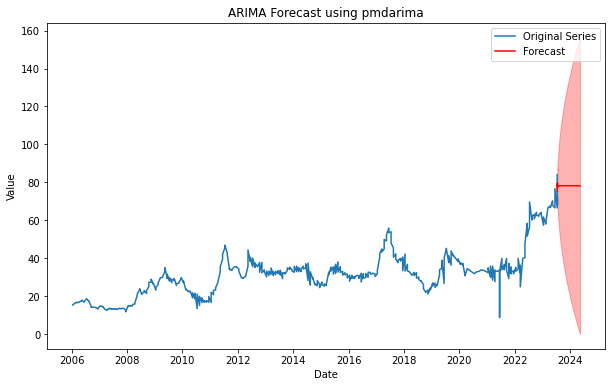

          date   forecast  lower_bound  upper_bound
417 2023-07-16  75.365926    68.618775    82.113076
418 2023-07-17  79.738895    72.193566    87.284224
419 2023-07-18  77.554997    68.469884    86.640110
420 2023-07-19  78.645654    68.628302    88.663007
421 2023-07-20  78.100971    67.061322    89.140619
..         ...        ...          ...          ...
712 2024-05-06  78.282389     0.733162   155.831615
713 2024-05-07  78.282389     0.602717   155.962061
714 2024-05-08  78.282389     0.472490   156.092287
715 2024-05-09  78.282389     0.342481   156.222296
716 2024-05-10  78.282389     0.212689   156.352089

[300 rows x 4 columns]


In [42]:
df = pd.DataFrame({
    'date': nairobi_dict['Wholesale']['Nairobi']['Maize']['date'],
    'value': nairobi_dict['Wholesale']['Nairobi']['Maize']['standardized_price']
})

#auto_arima model
model = auto_arima(df['value'], trace=True, suppress_warnings=True,seasonal=False)
b
# model summary
print(model.summary())

# fitted model
n_periods = 300
forecast, conf_int = model.predict(n_periods=n_periods, return_conf_int=True)
forecast_start_date = df['date'].iloc[-1] + pd.DateOffset(1)
forecast_dates = pd.date_range(forecast_start_date, periods=n_periods, freq='D')

#  DataFrame for the forecast
forecast_df = pd.DataFrame({
    'date': forecast_dates,
    'forecast': forecast,
    'lower_bound': conf_int[:, 0],
    'upper_bound': conf_int[:, 1]
})

# Plotting the original series and forecasted values
plt.figure(figsize=(10, 6))
plt.plot(df['date'], df['value'], label='Original Series')
forecast_start_date = df['date'].iloc[-1] + pd.DateOffset(1)
forecast_dates = pd.date_range(forecast_start_date, periods=n_periods, freq='D')
plt.plot(forecast_dates, forecast, label='Forecast', color='red')
plt.fill_between(forecast_dates, conf_int[:, 0], conf_int[:, 1], color='red', alpha=0.3)
plt.title('ARIMA Forecast using pmdarima')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()

print(forecast_df)

In [43]:
# import numpy as np
# # Extract all commodity data from nested_dict
# commodity_data = []
# for item in nested_dict.values():
#     for sub_item in item.values():
#         for sub_sub_item in sub_item.values():
#             commodity_data.append(sub_sub_item)

# # Create a new DataFrame encompassing all commodities
# df_all_commodities = pd.DataFrame({
#     'date': [data['date'] for data in commodity_data],
#     'value': [data['standardized_price'] for data in commodity_data]
# })

# # Run auto_arima model
# model_all_commodities = auto_arima(df_all_commodities['value'], trace=True, suppress_warnings=True)

# # Get forecast for all commodities
# n_periods = 10
# forecast_all, conf_int_all = model_all_commodities.predict(n_periods=n_periods, return_conf_int=True)
# forecast_start_date = df_all_commodities['date'].iloc[-1] + pd.DateOffset(1)
# forecast_dates = pd.date_range(forecast_start_date, periods=n_periods, freq='D')

# # Create DataFrame for the forecast for all commodities
# forecast_df_all = pd.DataFrame({
#     'date': forecast_dates,
#     'forecast': forecast_all,
#     'lower_bound': conf_int_all[:, 0],
#     'upper_bound': conf_int_all[:, 1]
# })

# # Plotting the original series and forecasted values for all commodities
# plt.figure(figsize=(10, 6))
# plt.plot(df_all_commodities['date'], df_all_commodities['value'], label='Original Series')
# plt.plot(forecast_dates, forecast_all, label='Forecast', color='red')
# plt.fill_between(forecast_dates, conf_int_all[:, 0], conf_int_all[:, 1], color='red', alpha=0.3)
# plt.title('ARIMA Forecast for All Commodities in Nairobi')
# plt.xlabel('Date')
# plt.ylabel('Value')
# plt.legend()
# plt.show()

# # Print the forecast DataFrame for all commodities
# print(forecast_df_all)

In [44]:
import pickle

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


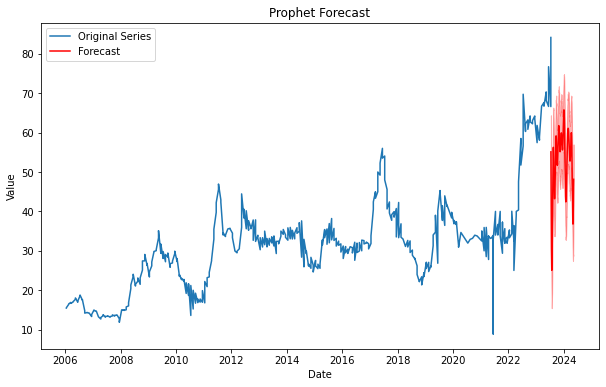

,date,forecast,lower_bound,upper_bound
208,2023-07-16,55.108629,45.388182,64.371014
209,2023-07-17,50.850876,41.626329,60.532397
210,2023-07-18,46.728709,37.237615,56.856635
211,2023-07-19,42.813039,33.368333,52.151432
212,2023-07-20,39.169647,30.076110,49.077572
...,...,...,...,...
503,2024-05-06,39.859617,30.517676,49.782462
504,2024-05-07,41.482972,32.652733,51.080802
505,2024-05-08,43.422734,34.103242,52.580254
506,2024-05-09,45.653223,36.684480,55.663591


In [45]:
df_prophet = pd.DataFrame({
    'ds': df['date'],
    'y': df['value']
})

# Creating a Prophet model and fitting it to the data
model_prophet = Prophet()
model_prophet.fit(df_prophet)

# Creating a future dataframe for making predictions
future = model_prophet.make_future_dataframe(periods=n_periods)

# Making predictions using the Prophet model
forecast_prophet = model_prophet.predict(future)

# Extracting the required columns from the forecast dataframe
forecast_dates = forecast_prophet['ds'].tail(n_periods)
forecast_values = forecast_prophet['yhat'].tail(n_periods)
lower_bound = forecast_prophet['yhat_lower'].tail(n_periods)
upper_bound = forecast_prophet['yhat_upper'].tail(n_periods)


# Creating a new DataFrame for the Prophet forecast
forecast_df_prophet = pd.DataFrame({
    'date': forecast_dates,
    'forecast': forecast_values,
    'lower_bound': lower_bound,
    'upper_bound': upper_bound
})

# Plotting the original series and forecasted values using Prophet
plt.figure(figsize=(10, 6))
plt.plot(df_prophet['ds'], df_prophet['y'], label='Original Series')
plt.plot(forecast_dates, forecast_values, label='Forecast', color='red')
plt.fill_between(forecast_dates, lower_bound, upper_bound, color='red', alpha=0.3)
plt.title('Prophet Forecast')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()

# Printing the Prophet forecast DataFrame
#print(forecast_df_prophet)
# print(model_prophet.stan_backend.stan_fit)
#fig1 = model_prophet.plot(forecast_prophet)

# Plot the components
#fig2 = model_prophet.plot_components(forecast_prophet)
forecast_df_prophet


In [46]:
from prophet.diagnostics import cross_validation, performance_metrics
from prophet.plot import plot_cross_validation_metric
import matplotlib.pyplot as plt

# Assume m is your fitted Prophet model
df_cv = cross_validation(model_prophet, initial='730 days', period='180 days', horizon='365 days')
df_p = performance_metrics(df_cv)

print(df_p.head())

# Plotting cross validation metric
# fig = plot_cross_validation_metric(df_cv, metric='mape')
# plt.show()

INFO:prophet:Making 30 forecasts with cutoffs between 2008-03-30 00:00:00 and 2022-07-15 00:00:00



  horizon        mse      rmse       mae      mape     mdape     smape  \
0 37 days  44.356091  6.660037  4.797210  0.139961  0.115239  0.143289   
1 40 days  42.147767  6.492131  4.618113  0.135443  0.109136  0.137951   
2 41 days  44.270252  6.653589  4.739540  0.143633  0.111740  0.142924   
3 42 days  45.746162  6.763591  4.901290  0.151072  0.115239  0.148882   
4 45 days  44.947176  6.704265  4.824931  0.148396  0.115239  0.146605   

   coverage  
0  0.707143  
1  0.721429  
2  0.707143  
3  0.685714  
4  0.692857  


In [47]:
print(df_p.head())

  horizon        mse      rmse       mae      mape     mdape     smape  \
0 37 days  44.356091  6.660037  4.797210  0.139961  0.115239  0.143289   
1 40 days  42.147767  6.492131  4.618113  0.135443  0.109136  0.137951   
2 41 days  44.270252  6.653589  4.739540  0.143633  0.111740  0.142924   
3 42 days  45.746162  6.763591  4.901290  0.151072  0.115239  0.148882   
4 45 days  44.947176  6.704265  4.824931  0.148396  0.115239  0.146605   

   coverage  
0  0.707143  
1  0.721429  
2  0.707143  
3  0.685714  
4  0.692857  


In [48]:
def comod(df,nested_dict):
    item = []
    print(df['pricetype'].unique())
    item1 = input("Enter the price type from the list: ")
    if item1 not in df['pricetype'].unique():
        print('Kindly enter a valid option: ')
        print(df['pricetype'].unique())
        item1 = input("Enter the price type from the list: ")
    item.append(item1)
    print(df[df['pricetype'] == item1]['district'].unique())
    item2 = input("Enter the market you are looking for from the list: ")
    if item2 not in df[df['pricetype'] == item1]['district'].unique():
        print('Kindly enter a valid option: ')
        print(df[df['pricetype'] == item1]['district'].unique())
        item2 = input("Enter the market you are looking for from the list: ")
    item.append(item2)
    print(df[(df['pricetype'] == item1) & (df['district'] == item2)]['commodity'].unique())
    item3 = input("Enter the commodity you wish from the existing list: ")
    if item3 not in df[(df['pricetype'] == item1) & (df['district'] == item2)]['commodity'].unique():
        print('Kindly enter a valid option: ')
        print(df[(df['pricetype'] == item1) & (df['district'] == item2)]['commodity'].unique())
        item3 = input("Enter the commodity you wish from the existing list: ")
    item.append(item3)
    ref = nested_dict
    for i in item:
        ref = ref[i]
    return ref



def arima_model(ref):
    import pandas as pd
    date_input = input('Enter desired date (YYYY-MM-DD): ')
    date_r = pd.to_datetime(date_input)
    n = (date_r - ref['date'].iloc[-1]).days  # Access the last date in 'ref'
    print("\n")
    print('Model in Progress: ')
    print("\n")
    import matplotlib.pyplot as plt
    from pmdarima import auto_arima
    import numpy as np

    df = pd.DataFrame({
        'date': ref['date'],
        'value': ref['standardized_price']
    })

    # auto_arima model
    model = auto_arima(df['value'], trace=True, suppress_warnings=True, seasonal=False)

    # model summary
    print(model.summary())

    # fitted model
    n_periods = int(n)
    forecast, conf_int = model.predict(n_periods=n_periods, return_conf_int=True)
    forecast_start_date = df['date'].iloc[-1] + pd.DateOffset(1)
    forecast_dates = pd.date_range(forecast_start_date, periods=n_periods, freq='D')

    # DataFrame for the forecast
    forecast_df = pd.DataFrame({
        'date': forecast_dates,
        'forecast': forecast,
        'lower_bound': conf_int[:, 0],
        'upper_bound': conf_int[:, 1]
    })

    # Plotting the original series and forecasted values
    plt.figure(figsize=(10, 6))
    plt.plot(df['date'], df['value'], label='Original Series')
    forecast_start_date = df['date'].iloc[-1] + pd.DateOffset(1)
    forecast_dates = pd.date_range(forecast_start_date, periods=n_periods, freq='D')
    plt.plot(forecast_dates, forecast, label='Forecast', color='red')
    plt.fill_between(forecast_dates, conf_int[:, 0], conf_int[:, 1], color='red', alpha=0.3)
    plt.title(f'ARIMA price Forecast for {ref["commodity"].unique()[0]} ')
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

    #print(forecast_df[forecast_df['date']==date_r])
    p_price=forecast_df[forecast_df["date"]==date_r]["forecast"].values[0]
    print(f'The price forecast for {ref["commodity"].unique()[0]} on {date_r.strftime("%Y-%m-%d")} is estimated to be KES {p_price}')
def prophet(ref):
  import pandas as pd
  date_input = input('Enter desired date (YYYY-MM-DD): ')
  date_r = pd.to_datetime(date_input)
  n = (date_r - ref['date'].iloc[-1]).days  # Access the last date in 'ref'
  print("\n")
  print('Model in Progress: ')
  print("\n")

  df_prophet = pd.DataFrame({
      'ds': ref['date'],
      'y': ref['standardized_price']
  })

  # Creating a Prophet model and fitting it to the data
  model_prophet = Prophet()
  model_prophet.fit(df_prophet)
  n_periods = int(n)
  # Creating a future dataframe for making predictions
  future = model_prophet.make_future_dataframe(periods=n_periods)

  # Making predictions using the Prophet model
  forecast_prophet = model_prophet.predict(future)

  # Extracting the required columns from the forecast dataframe
  forecast_dates = forecast_prophet['ds'].tail(n_periods)
  forecast_values = forecast_prophet['yhat'].tail(n_periods)
  lower_bound = forecast_prophet['yhat_lower'].tail(n_periods)
  upper_bound = forecast_prophet['yhat_upper'].tail(n_periods)


  # Creating a new DataFrame for the Prophet forecast
  forecast_df_prophet = pd.DataFrame({
      'date': forecast_dates,
      'forecast': forecast_values,
      'lower_bound': lower_bound,
      'upper_bound': upper_bound
  })

  # Plotting the original series and forecasted values using Prophet
  plt.figure(figsize=(10, 6))
  plt.plot(df_prophet['ds'], df_prophet['y'], label='Original Series')
  plt.plot(forecast_dates, forecast_values, label='Forecast', color='red')
  plt.fill_between(forecast_dates, lower_bound, upper_bound, color='red', alpha=0.3)
  plt.title('Prophet Forecast')
  plt.xlabel('Date')
  plt.ylabel('Value')
  plt.legend()
  plt.show()

  #print(forecast_df_prophet[forecast_df_prophet['date']==date_r])
  p_price=forecast_df_prophet[forecast_df_prophet["date"]==date_r]["forecast"].values[0]
  print(f'The price forecast for {ref["commodity"].unique()[0]} on {date_r.strftime("%Y-%m-%d")} is estimated to be KES {round(p_price,2)}')



['Wholesale' 'Retail']
Enter the price type from the list: Retail
['Nairobi']
Enter the market you are looking for from the list: Nairobi
['Milk' 'Oil (vegetable)' 'Maize' 'Potatoes' 'Sorghum' 'Beans']
Enter the commodity you wish from the existing list: Milk
Enter desired date (YYYY-MM-DD): 2024-05-06


Model in Progress: 


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1822.238, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1925.042, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1847.036, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1830.364, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1923.160, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1833.126, Time=0.07 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1820.499, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1830.083, Time=0.06 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1843.051, Time=0.06 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept  

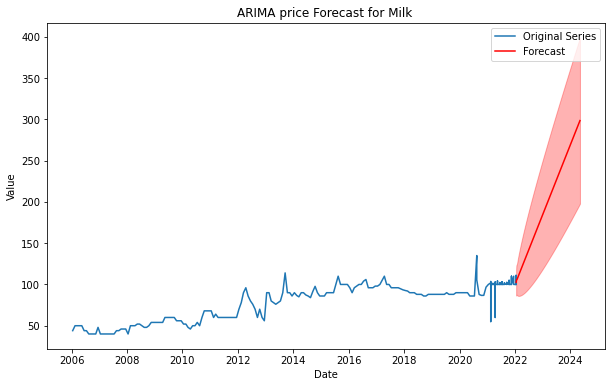

The price forecast for Milk on 2024-05-06 is estimated to be KES 298.49456816483564


In [53]:
arima_model(comod(df_nairobi,nairobi_dict))


['Wholesale' 'Retail']
Enter the price type from the list: Retail
['Nairobi']
Enter the market you are looking for from the list: Nairobi
['Milk' 'Oil (vegetable)' 'Maize' 'Potatoes' 'Sorghum' 'Beans']
Enter the commodity you wish from the existing list: Milk
Enter desired date (YYYY-MM-DD): 2024-05-06


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.




Model in Progress: 




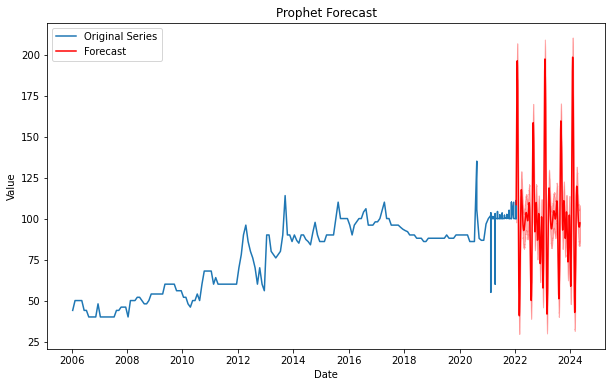

The price forecast for Milk on 2024-05-06 is estimated to be KES 97.34


In [55]:
prophet(comod(df_nairobi,nairobi_dict))

In [52]:
# Save the model to a file
with open('arima_model.pkl', 'wb') as pkl:
    pickle.dump(model, pkl)